# 4. 下游分析2

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scanpy as sc
import scvelo as scv
import velovgi

Global seed set to 0
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
from torch_geometric import seed_everything

seed = 0
seed_everything(seed)

读取数据

In [3]:
# 红系成熟部分
# adata_filename = "./data/erythroid_lineage.h5ad"
adata_filename = "/home/huang/PyCode/scRNA/data/Gastrulation/erythroid_lineage.h5ad" # 实验室服务器的数据路径

adata = scv.read(adata_filename)
batch_key = "stage"
cluster_key = "celltype"
adata

AnnData object with n_obs × n_vars = 9815 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

## 预处理

In [4]:
batch_pair_list = None
batch_pair_list = [
    ["E7.0", "E7.25"],
    ["E7.25", "E7.5"],
    ["E7.5", "E7.75"],
    ["E7.75", "E8.0"],
    ["E8.0", "E8.25"],
    ["E8.25", "E8.5"],
]
knn_mask, bnn_mask, subsample_adata = velovgi.pp.preprocess(adata, sample_mode="random", batch_key=batch_key, batch_pair_list=batch_pair_list)

Filtered out 47456 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
calculating knn and bnn mask...
pair_list : [['E7.0', 'E7.25'], ['E7.25', 'E7.5'], ['E7.5', 'E7.75'], ['E7.75', 'E8.0'], ['E8.0', 'E8.25'], ['E8.25', 'E8.5']]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


smoothing...
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## 断点训练

In [5]:
model_epoch_sep_savedir = "./model/epoch_sep" # TODO: 这里保存路径以后需要更改
log_epoch_sep_save_dir = "./log/epoch_sep"

max_epochs = 500
epoch_list = [5, 205, 405] # TODO: 具体还得通过tensorboard看整体训练过程中的损失变化情况

max_epochs = 50
epoch_list = [1, 10, 25] # TODO: 具体还得通过tensorboard看整体训练过程中的损失变化情况


# 每次断点指定模型训练的epoch
sep_epoch_list = [epoch_list[0]] 
for i in range(1, len(epoch_list)):
    sep_epoch_list.append(epoch_list[i]-epoch_list[i-1])
# sep_epoch_list.append(max_epochs-epoch_list[-1]) # 最后这个不保存
sep_epoch_list

[1, 9, 15]

In [6]:
# from pytorch_lightning import loggers

# velovgi.tl.VELOVGI.setup_anndata(adata=subsample_adata, spliced_layer="Ms", unspliced_layer="Mu")
# velovgi_model = velovgi.tl.VELOVGI(subsample_adata)

# for i in range(len(epoch_list)):
#     epoch = epoch_list[i]
#     sep_epoch = sep_epoch_list[i] # 此次断点训练的epoch数目
#     print(epoch, sep_epoch)
#     name = "%d_epoch(max_epochs=%d)"%(epoch, max_epochs) # 模型的训练名称
#     logger = loggers.TensorBoardLogger(save_dir=log_epoch_sep_save_dir, name=name) # 构造日志文件
    
#     velovgi_model.train(max_epochs=sep_epoch, logger=logger, checkpoint_mode="checkpoint")
#     velovgi_model.save("%s/%s"%(model_epoch_sep_savedir, name))# 模型保存

## 读取断点训练结果，看看整体和基因速率图

1. 读取断点训练结果

In [7]:
# epoch_list = [5,405] # 这里可以不用全部读取，而是选择性地读取

In [8]:
name_list =[]
adata_list = []

for i in range(len(epoch_list)):
    epoch = epoch_list[i]
    name = "%d_epoch(max_epochs=%d)"%(epoch, max_epochs) # 模型的训练名称
    name_list.append(name)
    # 提取模型
    # model = velovgi.tl.VELOVGI.load("%s/%s"%(model_epoch_sep_savedir, name), adata=subsample_adata, use_gpu=True)
    model = velovgi.tl.VELOVGI.load("%s/%s"%(model_epoch_sep_savedir, name), adata=subsample_adata, use_gpu=False) # TODO: 这里需要调整使用CPU
     # 输出结果
    velovgi.tl.add_velovi_outputs_to_adata(subsample_adata, model)
    tmp_adata = adata.copy()
    velovgi.pp.moment_recover(tmp_adata, subsample_adata)
    adata_list.append(tmp_adata)
adata_list

INFO     File ./model/epoch_sep/1_epoch(max_epochs=50)/model.pt already downloaded                                 
INFO     File ./model/epoch_sep/10_epoch(max_epochs=50)/model.pt already downloaded                                
INFO     File ./model/epoch_sep/25_epoch(max_epochs=50)/model.pt already downloaded                                


[AnnData object with n_obs × n_vars = 9815 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
     uns: 'celltype_colors', 'neighbors', 'sample_recover'
     obsm: 'X_pca', 'X_umap'
     layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'velocity_u', 'fit_t'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 9815 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
     uns:

In [10]:
name_list.append("%d_epoch(max_epochs=%d)"%(max_epochs, max_epochs))
adata_list.append(velovgi.tl.read_adata("./data/adata"))

load ./data/adata/adata.h5ad
load ./data/adata/sample_recover.pkl


2. 绘制整体速率图

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


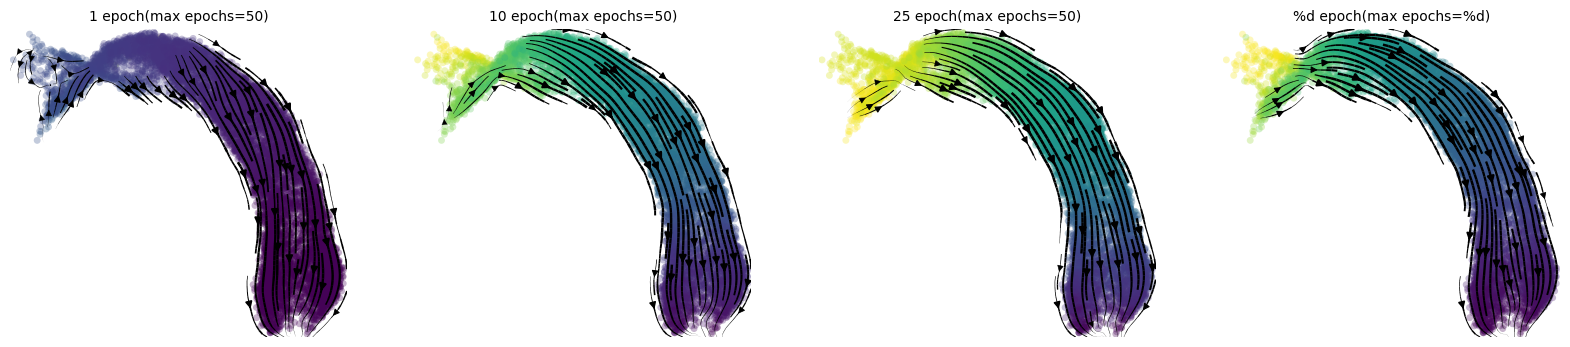

In [17]:
n = len(adata_list)
fig, ax = velovgi.pl.calc_fig(n)
for i in range(n):
    name = name_list[i]
    tmp_adata = adata_list[i]
    scv.tl.velocity_graph(tmp_adata) # 转移矩阵计算
    scv.tl.velocity_pseudotime(tmp_adata) # 速率的伪时间计算
    scv.pl.velocity_embedding_stream(tmp_adata, color="velocity_pseudotime", ax=ax[i], title=name, show=False, palette="plasma", colorbar=False)

/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


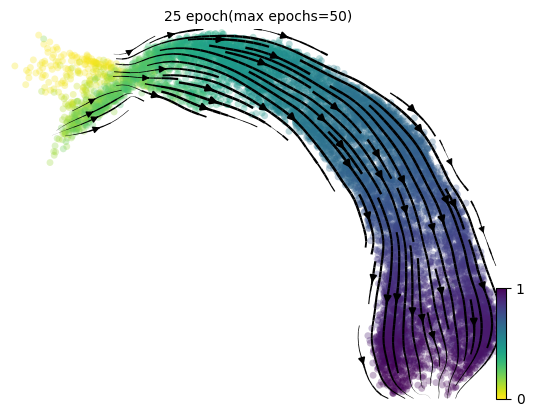

In [15]:
scv.pl.velocity_embedding_stream(adata_list[-1], color="velocity_pseudotime", title=name, palette="plasma", colorbar=True)

3. 绘制基因速率图，暂时这么绘制吧

In [12]:
# gene_list = list(adata.var[adata.var["MURK_gene"]].index)

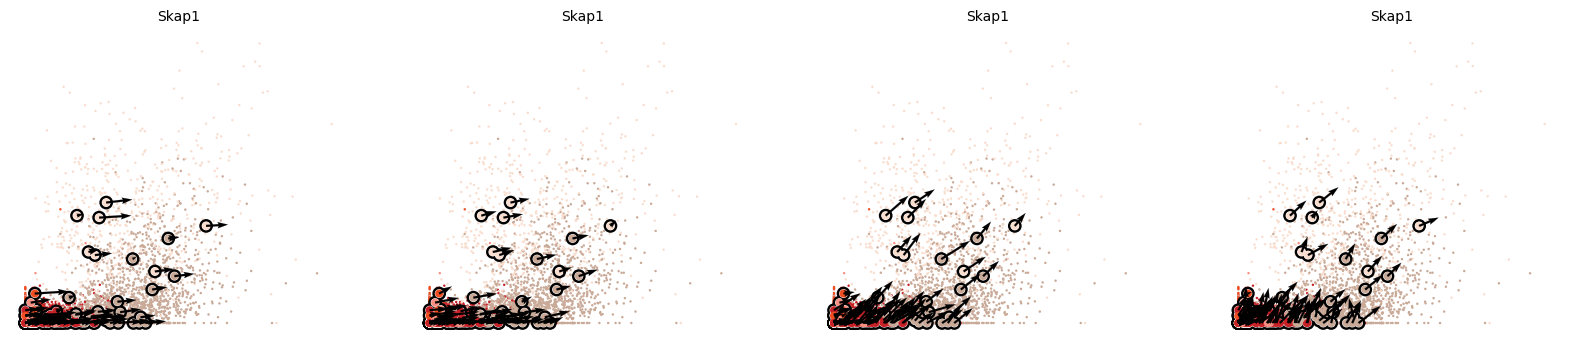

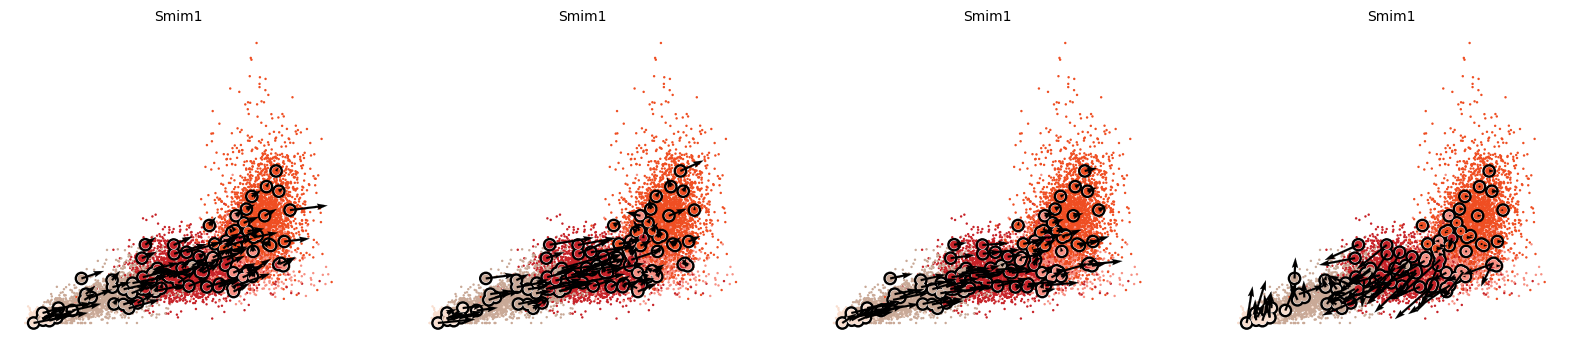

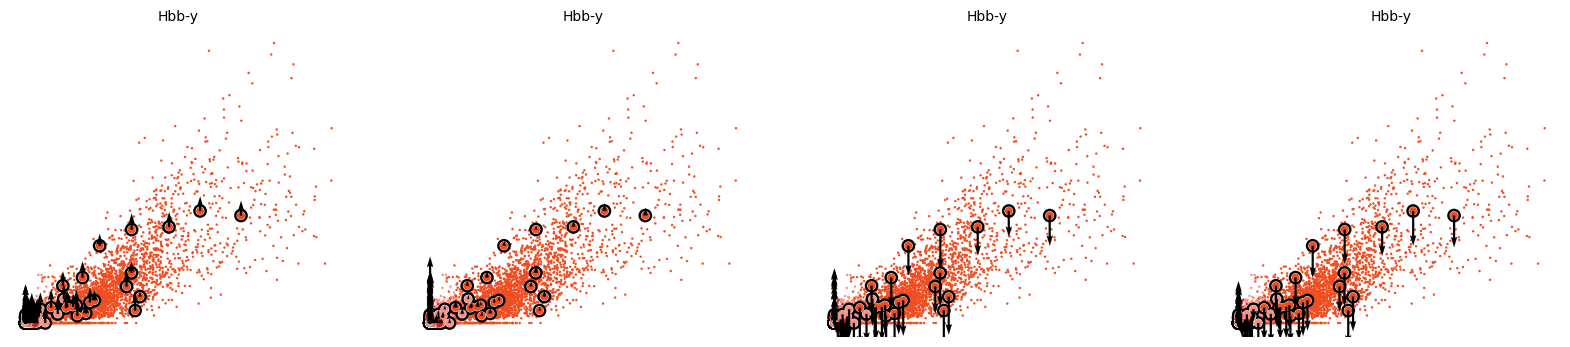

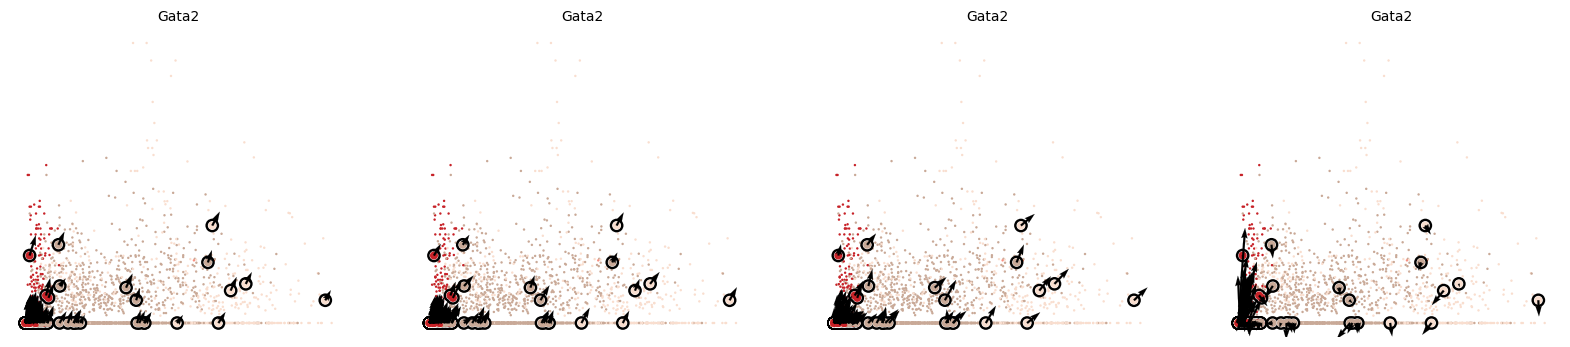

In [13]:
import math
import numpy as np
from scvelo.pl.utils import default_size


gene_list = ["Skap1", "Smim1", "Hbb-y", "Gata2"]

np.random.seed(0)
cell_num = adata.shape[0]
size = default_size(adata)*math.log(adata.shape[0]) # 箭头的缩放比例
# index_list = np.random.choice(np.arange(cell_num), size=int(cell_num*0.1), replace=False) # 部分细胞展示速率图
index_list = np.random.choice(np.arange(cell_num), size=int(cell_num*0.01), replace=False) # 部分细胞展示速率图


for gene in gene_list:
    item_figsize = (5, 4) # 单张图的figsize
    fig, ax = velovgi.pl.calc_fig(n, item_figsize=item_figsize) # 计算尺寸
    for i in range(n):
        name = name_list[i]
        adata = adata_list[i]
        tmp_adata = adata[index_list, gene_list]
        velovgi.pl.draw_velocity_gene(tmp_adata, adata, gene, cluster_key=cluster_key, size=size, ax=ax[i])